In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import *

2021.08.08

尝试使用proplot绘制平均图

使用pre_process/merge_cmorph_cn051.ipynb 下合并掉cmorph以及cmorph的数据·

## 数据读入

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/"
filename_obs  = "mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
filename_vr     = "mask_mean_t2m_98-17_VR.nc"
filename_rcm    = "mask_mean_t2m_98-17_RCM.nc"

ds_or = {}
ds_or['obs'] = xr.open_dataset(dir_in + filename_obs)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['obs'] = ds_or['obs']['tm']#[:,  :, :]
var['vr'] = ds_or['vr']['t2m'] - 273.15
var['rcm'] = ds_or['rcm']['t2m'] - 273.15

# var['obs'] = var['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

# change coords
var_list = ['obs', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['obs'].coords.keys()))
#     # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['obs']._coords
    var[i] = var[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [3]:
var_selmonth = {}
var_selmonth['mjja'] = {}
time_idx_mjja = var['obs'].time.dt.month.isin([5, 6, 7, 8])
for mod_name in ['obs', 'vr', 'rcm']:
    var_selmonth['mjja'][mod_name]  = var[mod_name].isel(time = time_idx_mjja)

## 计算年际相关系数

In [6]:
def scipy_count_corr_2d(a,b):
    '计算两个3D序列在时间维上的相关性，使用scipy逐个格点的计算，获取pvalues,输入数组a,b 按照 time x lat x lon的方式进行排列'
    '如果第一个时次出现了np.nan ,那么就对这个格点赋值为nan'
    import numpy as np
    from scipy import stats

    dim1 = a.shape[1]
    dim2 = a.shape[2]
    pvalues = np.empty(shape = a.shape[1:])
    corrvalues = np.empty(shape = a.shape[1:])
    # np.corrcoef?
    for ilat in range(0, dim1):
        for ilon in range(0, dim2):
            if ( (np.isnan(a[0,ilat,ilon])) | (np.isnan(b[0,ilat,ilon])) ):
                corrvalues[ilat, ilon], pvalues[ilat, ilon] = np.nan, np.nan
                continue    
            corrvalues[ilat, ilon], pvalues[ilat, ilon] \
                = stats.pearsonr(a[:,ilat,ilon], b[:,ilat,ilon])
    return [corrvalues, pvalues]

In [5]:
# 获取年际时间序列 var_interannual{} dict
var_interannual = {}
time_for_groupby = {}
time_for_groupby['mjja'] = var_selmonth['mjja']['vr'].time.dt.year

for iseason in ['mjja']:
    var_interannual[iseason] = {}
    for mod_name in ['obs', 'vr', 'rcm']:
        var_interannual[iseason][mod_name] = var_selmonth[iseason][mod_name].groupby(time_for_groupby[iseason]).mean(dim = 'time')

In [7]:
corr_interannual = {}

for iseason in ['mjja']:
    corr_interannual[iseason] = {}
    for mod_name in ['vr', 'rcm']:
        corr_interannual[iseason][mod_name]  = {}
        corr_interannual[iseason][mod_name]['corr']    = \
            xr.corr(var_interannual[iseason]['obs'], var_interannual[iseason][mod_name], dim= 'year')
        corr_scipy, pvalues_scipy = \
            scipy_count_corr_2d(var_interannual[iseason]['obs'].values, var_interannual[iseason][mod_name].values)
        corr_interannual[iseason][mod_name]['pvalues'] = xr.DataArray(pvalues_scipy, coords = \
            corr_interannual[iseason][mod_name]['corr'].coords, name = 'pvalues')

### 计算年际方差

2021.12.27 进行变率的分析

In [8]:
variance_interannual = {}
std_interannual = {}
for iseason in ['mjja']:
    variance_interannual[iseason] = {}
    std_interannual[iseason] = {}
    for mod_name in ['obs', 'vr','rcm']:
        variance_temp = var_interannual[iseason][mod_name].var(dim = "year")
        std_temp = var_interannual[iseason][mod_name].std(dim = "year")
        coords2d = {"lon":var_interannual[iseason][mod_name].lon, "lat":var_interannual[iseason][mod_name].lat}
        variance_interannual[iseason][mod_name] = xr.DataArray(variance_temp, coords = coords2d, name = 'variance')
        std_interannual[iseason][mod_name] = xr.DataArray(std_temp, coords = coords2d, name = 'variance')

### 计算年纪均方根误差

In [9]:
rmse_interannual = {}

for iseason in ['mjja']:
    rmse_interannual[iseason] = {}
    for mod_name in ['vr','rcm']:
        nyears = var_interannual[iseason][mod_name].year.shape[0]
        rmse_temp = np.sqrt( ( (var_interannual[iseason][mod_name].values - var_interannual[iseason]['obs'].values)**2).sum(axis = 0) / nyears)
        rmse_interannual[iseason][mod_name] = xr.DataArray(rmse_temp, coords = \
            corr_interannual[iseason][mod_name]['corr'].coords, name = 'rmse')

## 绘图部分

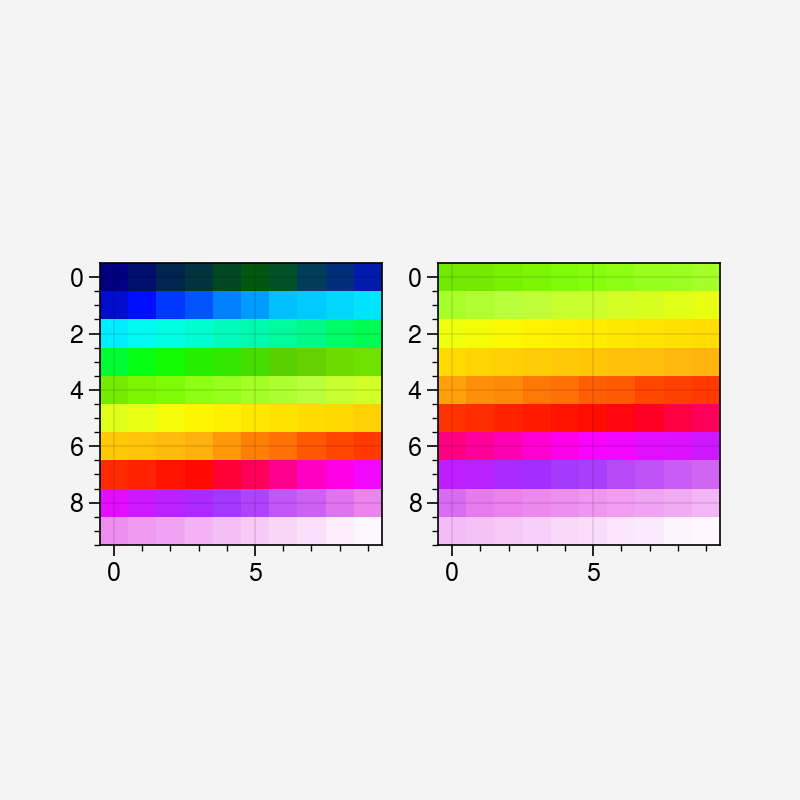

In [10]:
# 调整cmap，去掉gist_ncar 中深蓝色的部分
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cmaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

# cmap_corr     = plt.get_cmap('bwr')
cmap_corr     = cmaps.ncl_default
cmap_rmse     = plt.get_cmap('gist_ncar')
new_cmap_corr = truncate_colormap(cmap_corr, 0., 1.)
new_cmap_rmse = truncate_colormap(cmap_rmse, 0.4, 1.)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap_rmse)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap_rmse)
plt.show()

In [11]:
# 国内政区图的绘制
# Load the border data, CN-border-La.dat is download from
# https://gmt-china.org/data/CN-border-La.dat
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

cn_border_file = "/m2data2/yycheng/data_stage/CN-border/CN-border_line/CN-border-La.dat"
with open(cn_border_file) as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


In [12]:
def draw_borders(axs):
    # for ax_ind in axs:
    # for line in borders:
    # axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
    # axs.plot(line[0::10], line[1::10], lw = 0.4, color='black',transform=ccrs.Geodetic())
    ##---- 使用shp文件添加
    ## shapefile数据下载的位置：
    ## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
    # world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
    river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
    southsea_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "southsea_island.shp"
    ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"
    ## 来源： 沛沛的诸省 + 诸岛
    bou24p_shapefile     = "/m2data2/yycheng/data_stage/CN-border/peipeihelp/" + "bou2_4p.shp"
    ## 来源： https://www.resdc.cn/data.aspx?DATAID=200
    province_shapefile     = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"

    for ax in axs:
        # world     = shpreader.Reader(world_border_shapefile).geometries()
        river     = shpreader.Reader(river_border_shapefile).geometries()
        # bou24p    = shpreader.Reader(bou24p_shapefile).geometries()
        ninelines = shpreader.Reader(ninelines_shapefile).geometries()
        province  = shpreader.Reader(province_shapefile).geometries()
        ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
        # ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
        # ax.add_geometries(bou24p, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 沛沛map
        ax.add_geometries(province, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 地资所
        ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1)

### 画图renew
#### 2021.08.08
cn_border_file + shapefile ，但是存在重叠，尝试消除掉China边界，但是其他邻国边界无法处理；
#### 2021.08.09

不使用cn_border_file ，使用shapefile + coast_line（proplot自带） 的办法

shapefile有一些重叠，不绘制行政区

shapefile重新进行绘制，考虑来自 domain_info 中测试的多个shape file中挑选出地资所（改变了prj方式之后就可以正常绘制，具体查看prj后缀文件）进行使用

如果都使用环资所的全球、全国数据，那么是不会出现问题的

#### 2021.08.13
绘制相关性，使用hatch打点比较困难，这里直接考虑使用scatter打点，并且对过于密集的格点手动降低了密度 [::4] 散点大小约为1°

#### 2021.12.27
重新在此处添加年际变率（variance）的空间patterns的绘制，放弃之前的ncl脚本

### 绘制TCC RMSE

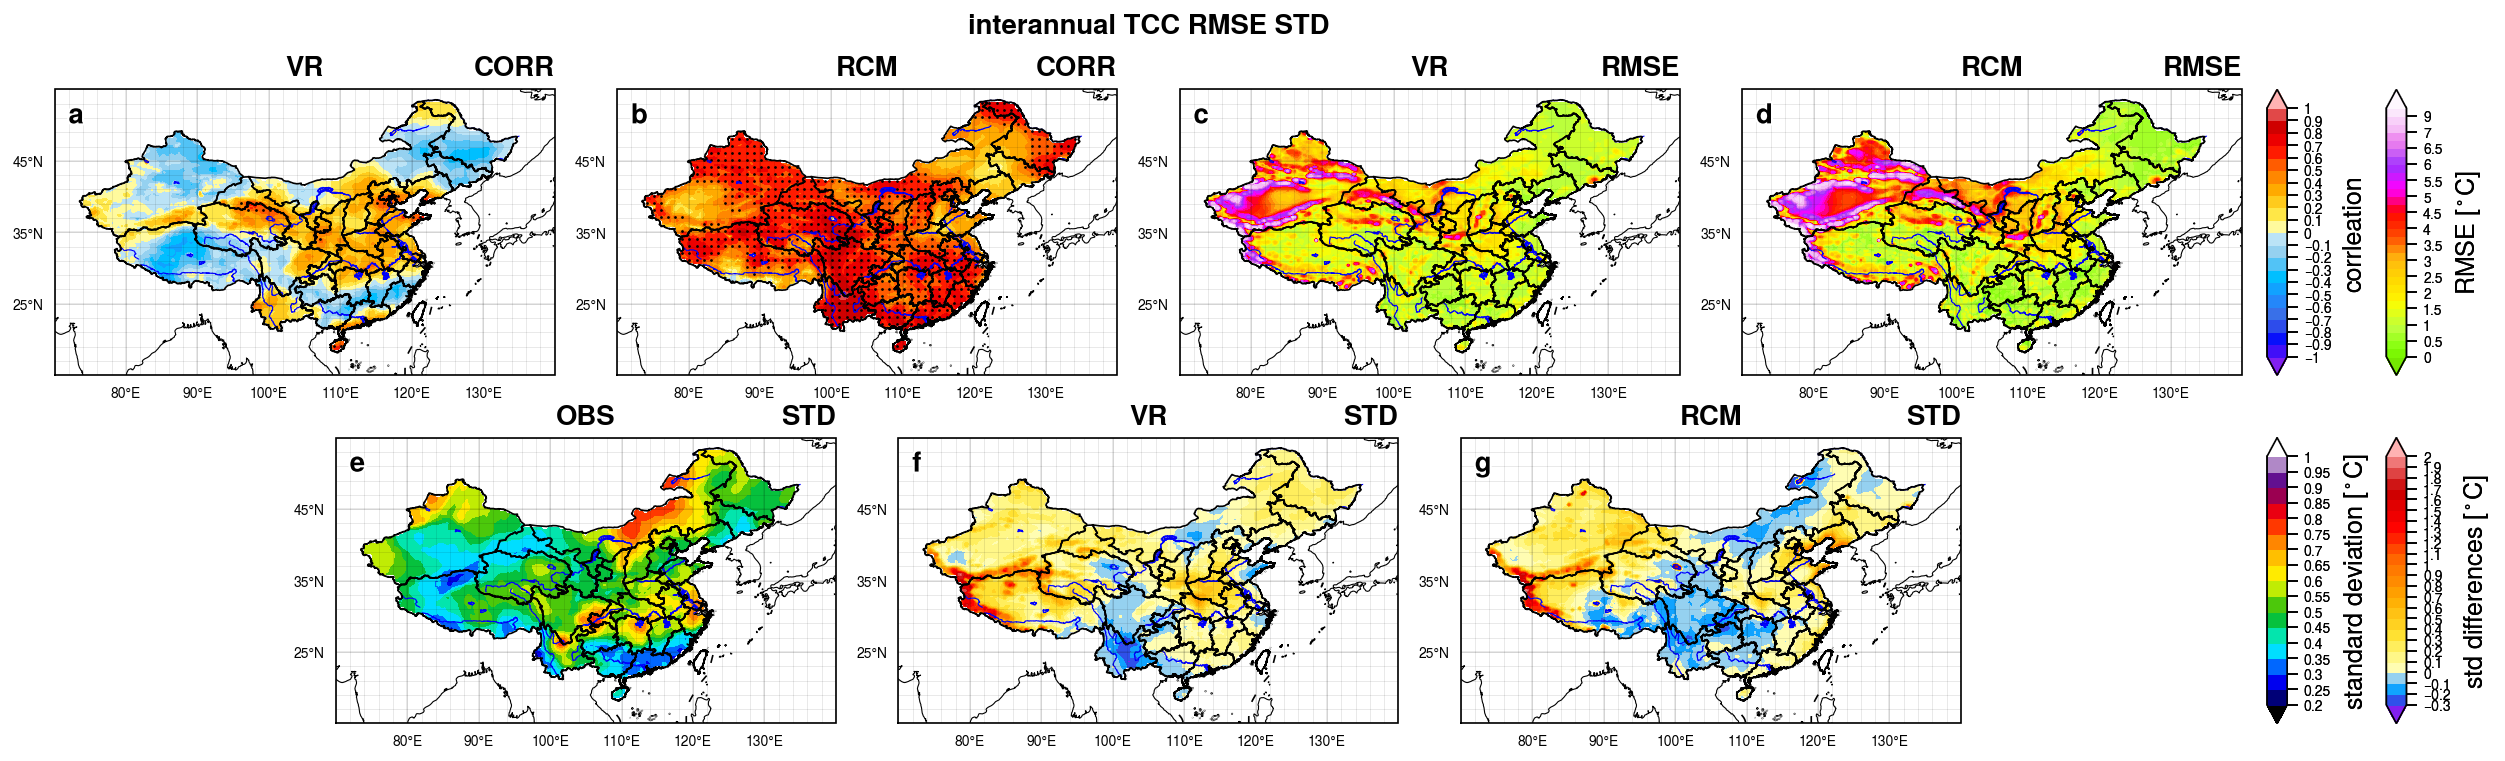

In [17]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

lon = corr_interannual['mjja']['vr']['corr'].lon.values
lat = corr_interannual['mjja']['vr']['corr'].lat.values

#----- create plot -----
subplot_shape = np.array([[1,1,2,2,3,3,4,4],[0,5,5,6,6,7,7,0]])
fig, axs = plot.subplots(subplot_shape, proj=('cyl'),space = 2.5)
m_contour_list = [] # 用于保存contour设置，后续设置colorbar使用

#----- 添加海洋以及行政区划 -----
draw_borders(axs)

#----- colorbar ticks 统一设置 -----
# cmap = 'gist_ncar'
# cmap = new_cmap
# cmap = cmap_data
corr_ticks = np.linspace(-1,1, 21)
# rmse_ticks = np.linspace(0, 7, 15)
rmse_ticks = np.concatenate((np.linspace(0,7,29),[8,9,10]), axis=0)
cmap_std = cmaps.BkBlAqGrYeOrReViWh200
# cmap_std_diff = cmaps.NCV_blue_red
cmap_std_diff = cmaps.ncl_default
std_ticks = np.linspace(0.2,1.,17)
std_ticks_diff = np.concatenate( (np.linspace(-0.3,-0.1,3), np.linspace(0,2.,21)), axis = 0) 

midnorm = pplt.DivergingNorm(vcenter = 0, fair = False)

# plot contourf and titile axs
# COR RMSE
plot_ind = 0
for season_ind, season_name in enumerate(['mjja']):
    for mod_ind, mod_name in enumerate(['vr','rcm']):
        # corr
        m_corr  = axs[plot_ind].contourf(lon, lat, corr_interannual[season_name][mod_name]['corr'].values,\
        levels=corr_ticks,cmap=new_cmap_corr, extend = 'both')
        # 绘制散点
        # 需要将原本密集的格点散点减少 (::4) 然后找到减少后的经纬度lon[::4] 进行散点的绘制
        scatter_test = np.argwhere((corr_interannual[season_name][mod_name]['pvalues'][::4,::4]<0.05).values)
        axs[plot_ind].scatter(lon[::4][scatter_test[:,1]],lat[::4][scatter_test[:,0]], s=0.15, color = 'k', marker='o')
        axs[plot_ind].format(title = mod_name.upper(), rtitle = 'CORR')
        
        # rmse
        m_rmse  = axs[plot_ind + 2].contourf(lon, lat, rmse_interannual[season_name][mod_name].values,\
        levels=rmse_ticks,cmap=new_cmap_rmse, extend = 'both')
        axs[plot_ind + 2].format(title = mod_name.upper(), rtitle = 'RMSE')
        plot_ind = plot_ind + 1

# STD
plot_ind = 4
for season_ind, season_name in enumerate(['mjja']):
    for mod_ind, mod_name in enumerate(['obs','vr','rcm']):
        # std
        if (mod_name == 'obs'):
            m_std  = axs[plot_ind].contourf(lon, lat, std_interannual[season_name][mod_name].values,\
            levels=std_ticks,cmap=cmap_std, norm = 'segmented', extend = 'both')
        else:
            m_std_diff  = axs[plot_ind].contourf(lon, lat, std_interannual[season_name][mod_name].values - std_interannual[season_name]['obs'].values,\
            levels=std_ticks_diff,cmap=cmap_std_diff, norm = midnorm, discrete = True, extend = 'both')
        axs[plot_ind].format(title = mod_name.upper(), rtitle = 'STD')
        plot_ind = plot_ind + 1

#----- add color bar-----

fig.colorbar(m_corr, loc='r', width=0.1, rows = (1,1),
ticklabelsize=5,ticks=corr_ticks, title='corrleation', extend = 'both')

fig.colorbar(m_rmse, loc='r', width=0.1, rows = (1,1),
ticklabelsize=5,ticks=rmse_ticks[::2], title='RMSE ' + r"$[^\circ C]$", extend = 'both')

fig.colorbar(m_std, loc='r', width=0.1,rows = (2,2),norm = 'segmented',
ticklabelsize=5,ticks=std_ticks, title='standard deviation ' + r"$[^\circ C]$", extend = 'both')

fig.colorbar(m_std_diff, loc='r', width=0.1,rows = (2,2),
ticklabelsize=5,ticks=std_ticks_diff, title="std differences " + r"$[^\circ C]$", \
norm = midnorm, extend = 'both')

# ----- format setting -----
axs.format(
abc=True,
abcloc = 'ul',
#----- 地图底图设置 -----
# reso = 'x-hi',
reso = 'med',
# coast = False,
coast = True,
coastlinewidth = 0.4,
borders = False,
lakes = False,
land  = False,
ocean = False,
# cartopyautoextent = True, 
# borderslinewidth=.5,
labels = True,
longrid  = True,
latgrid  = True,
#-----GEO axis-----
lonlim=(70, 140), latlim=(15, 55),
gridlabelsize = 5,
gridminor = True,
lonlocator = np.arange(70,142,10),
latlocator = np.arange(5,65+2,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(5,65+2,2),
#-----line label-----
suptitle="interannual TCC RMSE STD",
titleweight = 'bold',
)

#----- save figure -----
fig.patch.set_facecolor('white')
fig.savefig('./output_pic/t2m_InterannualStats_2022.01.28.png', dpi=600, facecolor= "white")